In [1]:
using Optim, Distributions, Plots

# Monte-Carlo Evaluation of Direct Estimation

This note conducts a monte-carlo simulation for the direct estimation of a simple CES technology:

$$ y = (a x_{1}^\rho + (1-a)x_{2}^\rho)^{1/\rho}\exp(\xi_{y}) $$

where $\xi_{y}\sim\mathcal{N}(0,\sigma_\xi)$. We will consider two data-generating processes for the pair $x_{1},x_{2}$. In both cases we assume:

$$\log(x_{1}) \sim \mathcal{N}(3,1) $$

### Case 1

Case 1 assumes a form for the relative demand of $x_{1}$ and $x_{2}$ that follows:

$$ \frac{x_{2}}{x_{1}} = \left(\frac{a}{1-a}\pi\right)^{1/(\rho-1)} $$

where $\pi$ is the relative price. We assume that

$$ \log(\pi) \sim\mathcal{N}(0,\sigma_{\pi}) $$

Below is a function to generate the data according to this setup. It allows for the parameters that determine demand to be set separately from those that determine production.

In [2]:
function gen_data(p1,p2,N)
    (;δ,σξ,σπ) = p2
    rel_price = rand(LogNormal(0,σπ),N)
    x1 = rand(LogNormal(3.,1.),N)
    x2 = (p1.a/(1-p1.a))^(1/(p1.ρ-1)) .* rel_price.^(1/(p1.ρ-1)) .* x1
    y = δ * log.( (p2.a .* x1 .^ p2.ρ .+ (1 - p2.a) .* x2 .^ p2.ρ ) .^ (1/p2.ρ) ) .+ rand(Normal(0,σξ),N)
    return (;y,x1,x2,rel_price)
end

gen_data (generic function with 1 method)

### Case 2

In order to contrast the performance of direct estimation with a more naive data generating process, we alternatively assume that $x_{2}\sim\mathcal{N}(3,\sigma_{\pi})$. The function below simulates data under this alternative assumption.

In [3]:
function gen_data(p,N)
    (;a,ρ,σξ,δ,σπ) = p
    x1 = rand(LogNormal(3.,1),N)
    x2 = rand(LogNormal(3.,σπ),N)
    y = δ * log.( (a .* x1 .^ ρ .+ (1 - a) .* x2 .^ ρ ) .^ (1/ρ) ) .+ rand(Normal(0,σξ),N)
    return (;y,x1,x2)
end

gen_data (generic function with 2 methods)

## Case without Measurement Error (Estimating only $\rho$)

We first consider the case in which $x_{1}$ and $x_{2}$ are observed without measurement error, and hence the production parameters can be estimated directly using non-linear least squares on a log-transformation of the outcome equation. Given the normality of the residuals, this is equivalent to the maximum likelihood estimate. Below is code for the NLLS criterion:

In [4]:
function Q_nlls(p,data)
    (;y,x1,x2) = data
    (;ρ,a,δ) = p
    r2 = y .- δ * log.( (a .* x1 .^ ρ .+ (1 - a) .* x2 .^ ρ) .^ (1/ρ) )
    return sum(r2.^2)
end

Q_nlls (generic function with 1 method)

It will become clear that even in this very simple setting, the direct estimate of elasticity parameters can be very unstable. We will show this using monte-carlo simulation for different values of $\sigma_{\pi}$ (the standard deviation of relative prices) and sample size.

To simplify the point, we begin by assuming the true values of $a$ and $\delta$ and estimating $\rho$ exclusively. This is the cleanest and easiest way to demonstrate the issue. To simplify estimation when things get unstable, we set a lower bound on $\rho$ at -50.

We use sample sizes of 500, 1000, and 2000, and chose values of $\sigma_\pi\in\{0.5,1,1.5\}$.

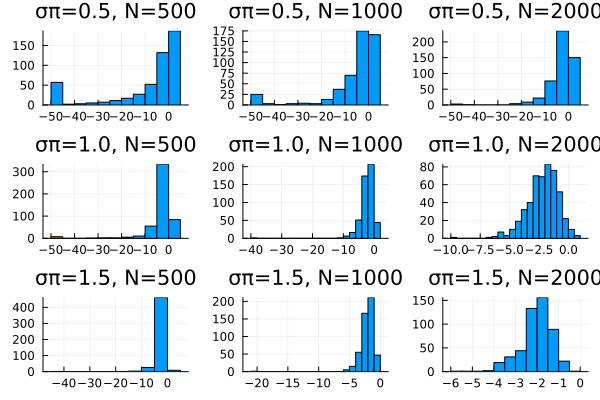

In [27]:
# set the true parameters
p = (;ρ = -2.,a = 0.5,δ = 0.2, σξ = 0.2, σπ = 1.)

function monte_carlo(N,B,p)
    Xb = zeros(B)
    for b in 1:B
        #println("Doing round $b of $B trials")
        dat = gen_data(p,p,N)
        res = optimize(x->Q_nlls((;p...,ρ=x),dat),-50.,1.) #[-2.]) #-300,1.) 
        Xb[b] = res.minimizer
    end
    return Xb
end

σπ_vec = [0.5,1.,1.5]
N_vec = [500,1_000,2_000]
H = []
for i in 1:3
    for j in 1:3
       p = (;p...,σπ = σπ_vec[i])
       Xb = monte_carlo(N_vec[j],500,p)
       push!(H,histogram(Xb,bins=20,title="σπ=$(σπ_vec[i]), N=$(N_vec[j])",legend=false))
    end
end
plot(H...)


It seems as if we would require unreasonable levels of price variation or sample size in order to reasonably pin down $\rho$, even without  the additional complications of estimating other parameters. To examine how much of this issue is generated by the assumed form of relative demand, we compare results using the alternative data generating process.

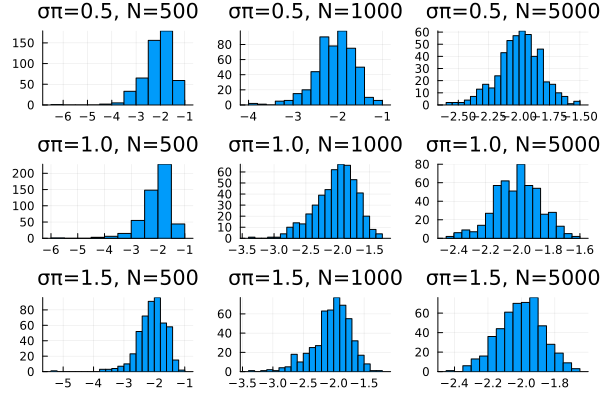

In [10]:
function monte_carlo_2(N,B,p)
    Xb = zeros(B)
    for b in 1:B
        #println("Doing round $b of $B trials")
        dat = gen_data(p,N)
        res = optimize(x->Q_nlls((;p...,ρ=x),dat),-100.,1.) #[-2.]) #-300,1.) 
        Xb[b] = res.minimizer
    end
    return Xb
end

σπ_vec = [0.5,1.,1.5]
N_vec = [500,1_000,2_000]
H = []
for i in 1:3
    for j in 1:3
       p = (;p...,σπ = σπ_vec[i])
       Xb = monte_carlo_2(N_vec[j],500,p)
       push!(H,histogram(Xb,bins=20,title="σπ=$(σπ_vec[i]), N=$(N_vec[j])",legend=false))
    end
end
plot(H...)

The simulation here exhibits much better behavior. To illustrate why, we compare the joint distributions of inputs in the two cases:

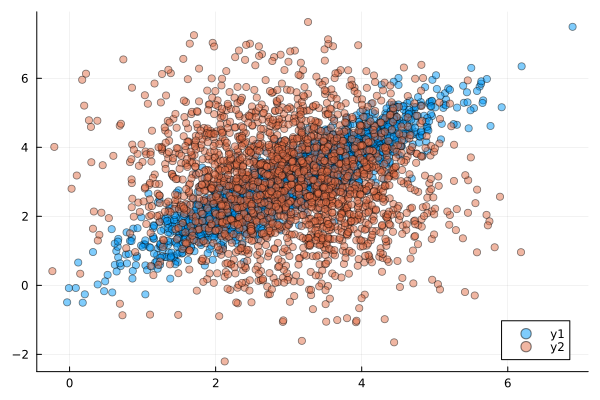

In [12]:
dat1 = gen_data(p,p,2_000)
dat2 = gen_data(p,2_000)
scatter(log.(dat1.x1),log.(dat1.x2),markeralpha=0.5)
scatter!(log.(dat2.x1),log.(dat2.x2),markeralpha=0.5)

The correlation in inputs induced by complementarity seems to increase uncertainty in $\hat{\rho}$.

## Estimating all parameters without measurement error

To see how performance may worsen when estimating all parameters, we return to case 1 and now attempt to estimate the triple $(\rho,a,\delta)$. The code below performs this monte-carlo trial and shows that the left tail of the distribution in finite sample does indeed move out substantially compared to the simpler case. Again we simplify estimation by setting a lower bound on $\rho$ at -50.

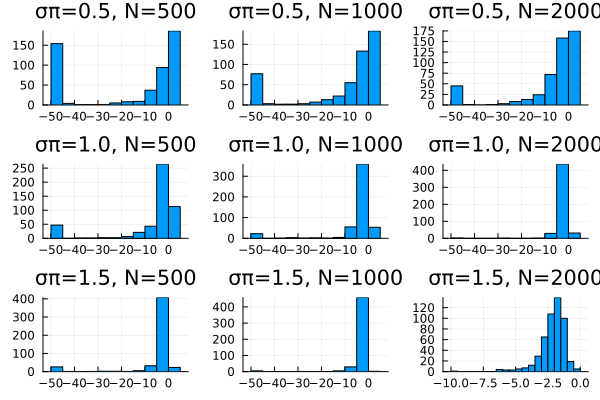

In [28]:
logit(x) = exp(x)/(1+exp(x))
logit_inv(x) = log(x/(1-x))

function monte_carlo_3(N,B,p)
    Xb = zeros(3,B)
    for b in 1:B
        #println("Doing round $b of $B trials")
        dat = gen_data(p,p,N)
        x0 = [p.ρ,p.a,p.δ]
        lower = [-50.,0.,0.]
        upper = [1.,1.,1.]
        res = optimize(x->Q_nlls((;ρ=x[1],a=x[2],δ = x[3]),dat),lower,upper,x0,Fminbox(LBFGS()),autodiff=:forward)
        Xb[:,b] = res.minimizer
    end
    return Xb
end

σπ_vec = [0.5,1.,1.5]
N_vec = [500,1_000,2_000]
H = []
for i in 1:3
    for j in 1:3
       p = (;p...,σπ = σπ_vec[i])
       Xb = monte_carlo_3(N_vec[j],500,p)
       push!(H,histogram(Xb[1,:],bins=20,title="σπ=$(σπ_vec[i]), N=$(N_vec[j])",legend=false))
    end
end
plot(H...)